In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

from matplotlib import colormaps

In [16]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [17]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [18]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [58]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
num_particles = 1000
# num_turns = 6000
num_turns = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [60]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end')])

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [65]:
tidp = install_tidp(line, block_mvt=29e-3)
tw = line.twiss4d()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

In [66]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2809114751256145


In [67]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [ ]:
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

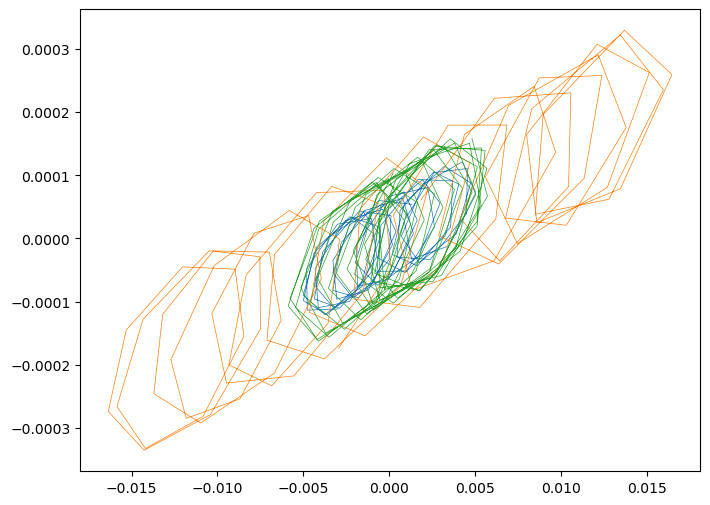

In [86]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for pid in range(3):
    x = monitor1.x[pid,:100]
    px = monitor1.px[pid,:100]
    ax.plot(x, px, lw=0.5)

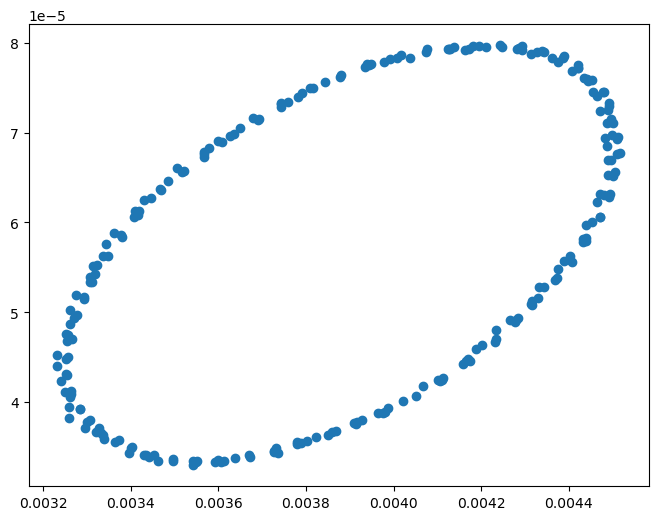

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=900
nturns = 6000

# mask = np.abs(monitor1.delta) < 0.00001
mask = monitor1.delta > 0.00085

x = monitor1.x[pid, :][mask[pid, :]]
px = monitor1.px[pid, :][mask[pid, :]]

ax.scatter(x, px)
# for t in range(nturns):
#     ax.plot(monitor1.x[pid, t], monitor1.px[pid, t], '.-', color=cmap(t/nturns))

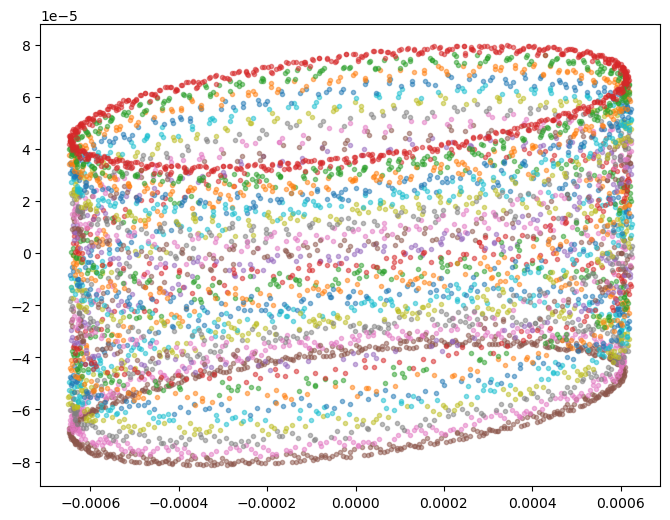

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=900
nturns = 6000
delta_ranges = np.linspace(np.min(monitor1.delta), np.max(monitor1.delta), 100)
for i in range(len(delta_ranges)-1):
    # if i % 5 != 0:
    #     continue
    mask = (monitor1.delta[pid, :] >= delta_ranges[i]) & (monitor1.delta[pid, :] < delta_ranges[i+1])
    ax.plot(monitor1.x[pid, :][mask]  - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[pid, :][mask], monitor1.px[pid, :][mask], '.', alpha=0.5)
# mask = np.abs(monitor1.delta) < 0.00001
mask = monitor1.delta > 0.00075

# for t in range(nturns):
#     ax.plot(monitor1.x[pid, t] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[pid, t], monitor1.px[pid, t], '.-', color=cmap(t/nturns))

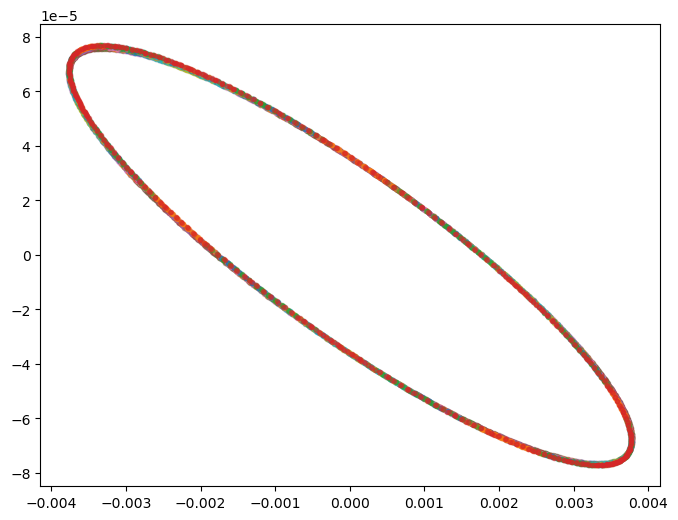

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=900
nturns = 6000
delta_ranges = np.linspace(np.min(monitor1.delta), np.max(monitor1.delta), 100)
for i in range(len(delta_ranges)-1):
    # if i % 5 != 0:
    #     continue
    mask = (monitor1.delta[pid, :] >= delta_ranges[i]) & (monitor1.delta[pid, :] < delta_ranges[i+1])
    ax.plot(monitor1.y[pid, :][mask]  , monitor1.py[pid, :][mask], '.', alpha=0.5)
# mask = np.abs(monitor1.delta) < 0.00001
mask = monitor1.delta > 0.00075

# for t in range(nturns):
#     ax.plot(monitor1.x[pid, t] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[pid, t], monitor1.px[pid, t], '.-', color=cmap(t/nturns))

In [182]:
tw.rows['monitor_qd31110'].dpx[0]

np.float64(0.06697704539167326)

In [146]:
mask = np.abs(monitor1.delta) < 0.00001

In [ ]:
monitor1.x[pid, :]

np.float64(0.0021735959233919753)

In [173]:
monitor1.x[pid, t]-tw.rows['monitor_qd31110'].dx[0] * monitor1[pid, t].delta

TypeError: 'ParticlesMonitor' object is not subscriptable

In [174]:
monitor1.x[pid, :][mask[pid, :]]

array([0.00405798, 0.00378995, 0.0032446 , 0.00315539, 0.00372317,
       0.00437528, 0.00444029, 0.00384996, 0.00328336, 0.00332205,
       0.00388587, 0.00424788, 0.00391184, 0.00400659, 0.00359518,
       0.00311875, 0.00324126, 0.00390847, 0.00446586, 0.0043159 ,
       0.00366971, 0.00322887, 0.00347382, 0.00406429, 0.00426623,
       0.00374831, 0.0039003 , 0.00339394, 0.00305425, 0.00336303,
       0.00409664, 0.00448866, 0.00416472, 0.00349573, 0.00324163,
       0.00365329, 0.00421499, 0.00422442, 0.00355785, 0.00374219,
       0.00322011, 0.00303234, 0.00353383, 0.00424862, 0.00446392,
       0.00397612, 0.00336295, 0.00331286, 0.0038461 , 0.00432475,
       0.00411824, 0.0033763 , 0.00356674, 0.00306174, 0.00308146,
       0.00371725, 0.00436794, 0.00437559, 0.00377922, 0.00328358,
       0.00342971, 0.00404461, 0.00436719, 0.00397966, 0.00319675,
       0.00278405, 0.0033621 , 0.00295872, 0.00318011, 0.00390731,
       0.00443361, 0.00423435, 0.00359982, 0.00325128, 0.00359

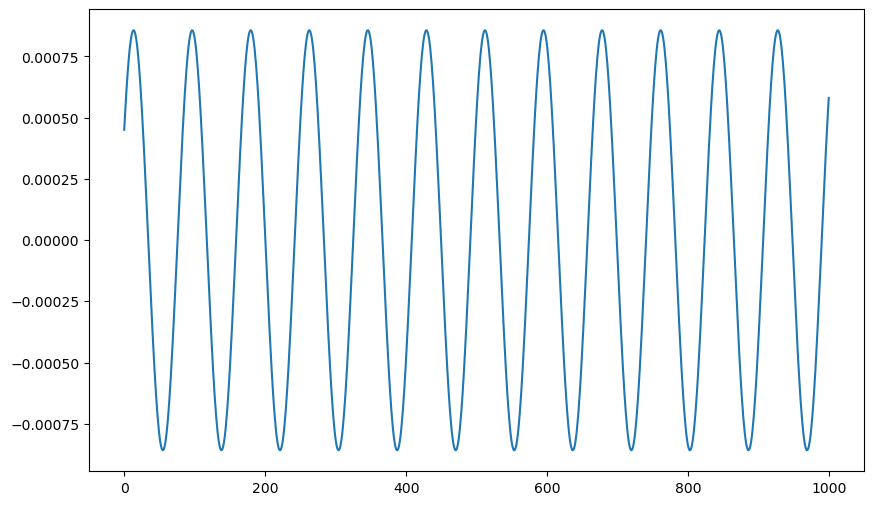

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

pid = 900
turns = np.linspace(0, num_turns-1, num_turns)
ax.plot(turns[:1000], monitor1.delta[pid, :1000])

In [128]:
part_init = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2809114751256145


In [ ]:
np.min(monitor1.x)